OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [1]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b
print(a)
print(b)


[[0.48324465 0.02705223 0.85226684]
 [0.79032628 0.58597243 0.04134577]]
tensor([[0.4832, 0.0271, 0.8523],
        [0.7903, 0.5860, 0.0413]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [3]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.7582],
        [0.9961]], grad_fn=<AddBackward0>)
tensor(1.7544, grad_fn=<SumBackward0>)
tensor([[0.6830],
        [1.1748]])
tensor([[0.2865],
        [0.7648]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.

In [4]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Let us examine the size of the dataset.

In [5]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?
# ...
# ...
import numpy as np

print(trainingdata.__len__)
print(testdata.__len__)
print("The number of features in each data point is %d." % len(list(np.ravel(trainingdata[0][0]))) )


<bound method MNIST.__len__ of Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./FashionMNIST/
    Split: Train
    StandardTransform
Transform: ToTensor()>
<bound method MNIST.__len__ of Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./FashionMNIST/
    Split: Test
    StandardTransform
Transform: ToTensor()>
The number of features in each data point is 784.


Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

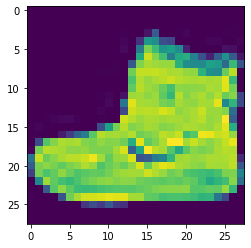

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = trainingdata[0]

# Q4.3 Assuming each sample is an image of size 28x28, show it in matplotlib.
image=image.reshape(28,28) 
plt.imshow(image)
plt.show()

Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches.

In [7]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([2, 7, 8, 6, 6, 6, 6, 6, 6, 6, 5, 0, 4, 9, 8, 9, 8, 1, 4, 1, 3, 6, 6, 9,
        6, 5, 8, 1, 9, 3, 3, 8, 0, 5, 8, 4, 7, 5, 6, 5, 9, 7, 5, 6, 5, 0, 0, 8,
        0, 3, 2, 4, 5, 7, 4, 0, 2, 8, 3, 5, 3, 7, 6, 8])


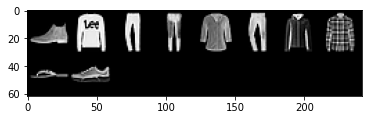

In [8]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.

images, label = next(iter(testDataLoader))
images_example = images[:10]
images_example = torchvision.utils.make_grid(images_example)
images_example = images_example.numpy().transpose(1,2,0) 
plt.imshow(images_example)
plt.show()

Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [9]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



Cool! Now we have set everything up. Let's try to train the network.

In [10]:
train_loss_history = []
test_loss_history = []

from torch.autograd import Variable
# Q4.5 Write down a for-loop that trains this network for 20 epochs, 
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to 
# execute the next code block.

with torch.no_grad():
     training_x=Variable(torch.unsqueeze(trainingdata.data, dim=1)).type(torch.FloatTensor)/255.
training_y=trainingdata.targets

with torch.no_grad():
     test_x=Variable(torch.unsqueeze(testdata.data, dim=1)).type(torch.FloatTensor)/255.
test_y=testdata.targets

for epoch in range(20):
    for step, (x, y) in enumerate(trainDataLoader):   
        b_x = Variable(x)   
        b_y = Variable(y)   
        output = net(b_x.cuda())         
        loss = Loss(output, b_y.cuda())   
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()

    #calculate and print train/test losses
    training_output = net(training_x.cuda())
    test_output = net(test_x.cuda())
    training_loss = Loss(training_output,training_y.cuda())
    test_loss = Loss(test_output,test_y.cuda())

    train_loss_history.append(training_loss)
    test_loss_history.append(test_loss)

    print("epoch_"+str(epoch+1)+":")
    print("train loss:"+str(training_loss.item()))
    print("test loss:"+str(test_loss.item()))

epoch_1:
train loss:0.7209498882293701
test loss:0.7389684319496155
epoch_2:
train loss:0.6269922256469727
test loss:0.6484988927841187
epoch_3:
train loss:0.5824095010757446
test loss:0.6058273315429688
epoch_4:
train loss:0.5562071204185486
test loss:0.5812960863113403
epoch_5:
train loss:0.5402321219444275
test loss:0.5673826932907104
epoch_6:
train loss:0.5223643183708191
test loss:0.5487931370735168
epoch_7:
train loss:0.51003497838974
test loss:0.5378562211990356
epoch_8:
train loss:0.5011770129203796
test loss:0.530402660369873
epoch_9:
train loss:0.4928666353225708
test loss:0.5224859714508057
epoch_10:
train loss:0.4871394634246826
test loss:0.5179532170295715
epoch_11:
train loss:0.48119115829467773
test loss:0.5122848749160767
epoch_12:
train loss:0.476009339094162
test loss:0.5071613192558289
epoch_13:
train loss:0.47180718183517456
test loss:0.5037179589271545
epoch_14:
train loss:0.4684552848339081
test loss:0.5005063414573669
epoch_15:
train loss:0.4652370810508728
test 

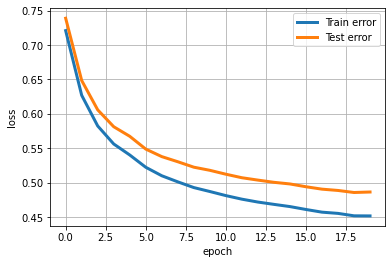

In [11]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [12]:
predicted_output = net(images.cuda())
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels.cuda())
print(labels)

torch.return_types.max(
values=tensor([ 6.2624,  8.8944, 12.1244, 10.9136,  4.1968,  8.5146,  5.7828,  5.1000,
         2.3824,  6.6692,  5.4665,  4.4449,  4.7136,  7.1716,  7.9132,  7.9524,
         4.5884,  5.2708,  5.6830,  9.7426,  4.6144,  5.6596,  9.6225,  6.2523,
        10.9543,  3.6557,  7.4659,  6.6152,  7.8315,  4.9271, 10.3881,  5.1096,
         4.9132,  6.3209,  6.6618,  4.9263,  7.5962,  4.1665,  8.4530, 10.3519,
         8.6693, 11.9572,  4.4583,  8.6453,  8.2881,  3.6127,  6.3004,  8.1692,
         3.9620,  6.7309,  6.9210,  3.5020,  2.6014,  6.5631,  4.3499,  6.8932,
         8.3772,  6.1975,  7.3587,  4.7915,  8.2412,  7.6006,  7.9083,  4.5640],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 6, 7, 7, 7,
        1, 2, 6, 0, 9, 6, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 9, 6, 7, 2, 1,
        2, 6, 6, 2, 5, 6, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5], device='cuda:0'))
tensor([2, 7, 8, 6, 6, 6, 6, 6, 6, 6

In [13]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  images, labels = iter(dataloader).next()
  predicted_output = net(images.cuda())
  
  y_pred_lst = torch.max(predicted_output, 1)[1].cpu().numpy().tolist()
  label_lst = labels.cpu().numpy().tolist()

  total_num = len(labels)
  correct_num = 0

  for i in range(len(y_pred_lst)):
    if y_pred_lst[i]==label_lst[i]:
      correct_num+=1
  #probability of successful classification    
  return correct_num/total_num


#evaluate the accuracy on the whole training/test dataset
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=len(trainingdata), shuffle=False)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=len(testdata), shuffle=False)

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))

Train acc = 0.85, test acc = 0.83
